In [1]:
from kan import *
import pytz
import time
import datetime
from data_process import data_process_without_norm
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import copy
import pandas as pd

df = data_process_without_norm()
df = df.drop("entsoe",axis=1)
loc_tz = pytz.timezone('Europe/Zurich')
split_date_train_ = loc_tz.localize(datetime.datetime(2016,1,1,0,0,0,0))
split_date_train = loc_tz.localize(datetime.datetime(2016,3,1,0,0,0,0))
split_date_test = loc_tz.localize(datetime.datetime(2016,3,15,0,0,0,0))

df_train_ = df.loc[(split_date_train_ < df.index)]
df_train = df_train_.loc[df_train_.index <= split_date_train].copy()
_temp_df = df.loc[split_date_test > df.index]
df_test = _temp_df.loc[_temp_df.index > split_date_train].copy()

# Input standardization
scaler_input = StandardScaler()
# scaler_input = MinMaxScalerr()
_temp_scaled_input_data = scaler_input.fit_transform(df_train.iloc[:,1:])
x_train_input = _temp_scaled_input_data

#Output standardization
scaler_output = StandardScaler()
# scaler_input = MinMaxScaler()
_temp_scaled_output_data = scaler_output.fit_transform(np.array(df_train.iloc[:,0]).reshape(-1,1))
x_train_label = _temp_scaled_output_data

#Test set standardization
x_test_input = scaler_input.transform(df_test.iloc[:,1:])
x_test_label = scaler_output.transform(np.array(df_test.iloc[:,0]).reshape(-1,1))

_temp_test_input = np.hstack((x_test_input[:,:8],x_test_input[:,-3:-1]))
_temp_test_label = x_test_label
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_temp_train_input = np.hstack((x_train_input[:, :8], x_train_input[:, -3:-1]))
_temp_train_label = x_train_label

# 将数据转换为 PyTorch 张量
train_input_tensor = torch.tensor(_temp_train_input.astype(np.float32))
train_label_tensor = torch.tensor(_temp_train_label.astype(np.float32))

test_input_tensor = torch.tensor(_temp_test_input.astype(np.float32))
test_label_tensor = torch.tensor(_temp_test_label.astype(np.float32))


In [2]:
# Find the best configuration
results_df = pd.read_csv('./parameters_configuration/KAN_BaseConfig_SPRING.csv',index_col=0).to_numpy()
best_config = results_df[results_df[:,-1].argmin(),:]

Best_step = best_config[0].astype(int)
Best_lr = best_config[1]
Best_grid = best_config[2].astype(int)
Best_k = best_config[3].astype(int)
Best_internal_units = best_config[4].astype(int)
Best_batch = best_config[5].astype(int)
Best_lamb = best_config[6].astype(float)
Best_lamb_entropy = best_config[7].astype(float)

print("\nBest Configuration: Step: {}, Learning Rate: {}, Grid: {}, K: {}, Internal Units: {}, Batch Size: {}, Lamb: {}, Lamb Entropy: {}".format(Best_step, Best_lr, Best_grid, Best_k, Best_internal_units, Best_batch, Best_lamb, Best_lamb_entropy))


Best Configuration: Step: 100, Learning Rate: 0.01, Grid: 12, K: 3, Internal Units: 16, Batch Size: 64, Lamb: 0.01, Lamb Entropy: 10.0


In [3]:
model = KAN(width=[10, int(Best_internal_units), 1], grid=Best_grid, k=Best_k, auto_save=False, seed=0, device=device)
dataset = dict()
dataset['train_input'] = torch.tensor(_temp_train_input.astype(np.float32))
dataset['train_label'] = torch.tensor(_temp_train_label.astype(np.float32))

dataset['test_input'] = torch.tensor(_temp_test_input.astype(np.float32))
dataset['test_label'] = torch.tensor(_temp_test_label.astype(np.float32))

for i in range(Best_internal_units):
    model.fix_symbolic(0, 9, i, 'sin', fit_params_bool=False)
    model.fix_symbolic(0, 8, i, 'sin', fit_params_bool=False)
        
model.auto_save = True
# model.fit(dataset, opt="LBFGS", steps=Best_step, batch=Best_batch, lr=Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy);
model.fit(dataset, opt="Adam", steps=Best_step, batch=Best_batch, lr=Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy);

saving model version 0.1


In [4]:

# Find the best configuration
results_df = pd.read_csv('./parameters_configuration/NN+KAN-SPIRNG.csv',index_col=0).to_numpy()
best_config = results_df[results_df[:,-1].argmin(),:]
Best_threshold_1 = best_config[0]
Best_threshold_2 = best_config[1]
print("\nBest Configuration: Best_threshold_1: {}, Best_threshold_2: {}".format(Best_threshold_1, Best_threshold_2))


Best Configuration: Best_threshold_1: 0.02, Best_threshold_2: 0.02


saving model version 0.1


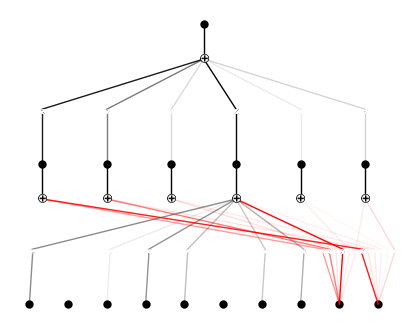

In [5]:
model = model.prune(node_th=Best_threshold_1, edge_th=Best_threshold_2);
model.auto_save = True
model.fit(dataset, opt="Adam", steps=Best_step, batch=Best_batch, lr=Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy);
model.plot()

In [6]:
# source conde prune_input return input_mask
model,input_mask = model.prune_input()
# model.edge_scores
# model.node_scores

keep: [True, False, True, True, True, False, True, True, True, True]
saving model version 0.2


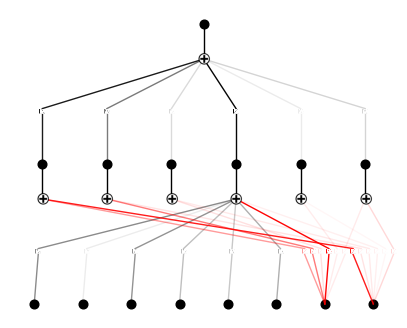

In [7]:
model.plot()

In [8]:
lib = ['x','x^2','exp','sqrt','tanh','sin','arctanh']
model.auto_symbolic(lib=lib)
# model.symbolic_formula()

fixing (0,0,0) with 0
fixing (0,0,1) with 0
fixing (0,0,2) with 0
fixing (0,0,3) with x, r2=0.6242073774337769, c=1
fixing (0,0,4) with 0
fixing (0,0,5) with 0
fixing (0,1,0) with 0
fixing (0,1,1) with 0
fixing (0,1,2) with 0
fixing (0,1,3) with x, r2=0.20360210537910461, c=1
fixing (0,1,4) with 0
fixing (0,1,5) with 0
fixing (0,2,0) with 0
fixing (0,2,1) with 0
fixing (0,2,2) with 0
fixing (0,2,3) with x, r2=0.8953628540039062, c=1
fixing (0,2,4) with 0
fixing (0,2,5) with 0
fixing (0,3,0) with 0
fixing (0,3,1) with 0
fixing (0,3,2) with 0
fixing (0,3,3) with x, r2=0.5155067443847656, c=1
fixing (0,3,4) with 0
fixing (0,3,5) with 0
fixing (0,4,0) with 0
fixing (0,4,1) with 0
fixing (0,4,2) with 0
fixing (0,4,3) with x, r2=0.2760308086872101, c=1
fixing (0,4,4) with 0
fixing (0,4,5) with 0
fixing (0,5,0) with 0
fixing (0,5,1) with 0
fixing (0,5,2) with 0
fixing (0,5,3) with x, r2=0.39706656336784363, c=1
fixing (0,5,4) with 0
fixing (0,5,5) with 0
skipping (0,6,0) since already symboli

In [9]:
# def revise_dataset(dataset,input_index):
#     dataset['train_input'] = dataset['train_input'][:,input_index]
#     dataset['test_input'] = dataset['test_input'][:,input_index]
#     return dataset
# true_indices = np.where(input_mask.detach().numpy())[0]
# dataset = revise_dataset(dataset,true_indices)
model.fit(dataset, opt="Adam", steps=Best_step, batch=Best_batch, lr=Best_lr);

saving model version 0.4


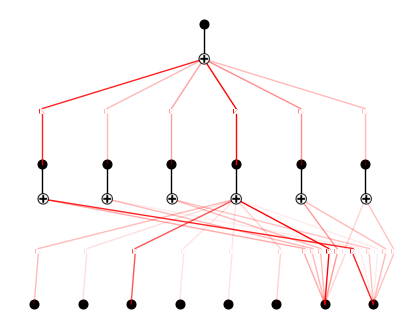

In [10]:
model.plot()

In [11]:
model.symbolic_formula()

([-0.147878405436938*x_1 + 0.0705247522572326*x_2 + 0.260715547621237*x_3 - 0.0595831004376474*x_4 - 0.0665124675244903*x_5 - 0.0961854641799234*x_6 - 0.199940860255781*sin(0.533616423606873*x_7 + 0.0406286790966988) - 0.0780071270595302*sin(0.713795185089111*x_7 - 0.146193221211433) + 0.120360933303804*sin(0.835395514965057*x_7 + 0.211806073784828) + 0.107377870258644*sin(1.29021561145782*x_7 + 0.318071395158768) + 0.961805992118203*sin(1.55316507816315*x_7 + 0.941126823425293) - 0.167863159751351*sin(1.58420360088348*x_7 + 0.322238087654114) + 0.140243869878714*sin(0.219426289200783*x_8 + 0.647644519805908) + 0.0422295616254414*sin(0.60089635848999*x_8 - 0.0163751244544983) - 0.114188251277058*sin(0.949861168861389*x_8 - 0.546780288219452) - 0.562417090685424*sin(1.06847858428955*x_8 - 0.472326159477234) - 0.126235427403802*sin(1.38979625701904*x_8 - 0.840504705905914) + 0.105112312769297*sin(1.8430061340332*x_8 + 0.181359648704529) - 0.397999839548226],
 [x_1, x_2, x_3, x_4, x_5, x_

In [12]:
def RMSE(_pre,_actual):
    MSE = ((_pre-_actual)**2)/15/24   
    return np.sqrt(MSE.sum())
    
def MAE(_pre,_actual):
    return (np.abs((_pre-_actual))).sum()/15/24
    
def MAPE(_pre,_actual):
    return ((np.abs((_pre-_actual)))/_actual).sum()/15/24
    
def evaluation(_pre,_actual): 
    return [RMSE(_pre,_actual),MAE(_pre,_actual),MAPE(_pre,_actual)]

In [13]:
pre_KAN = model.forward(dataset['test_input']).detach().numpy()

actual = scaler_output.inverse_transform(dataset['test_label'].reshape(-1,1))

pre_KAN_ = scaler_output.inverse_transform(pre_KAN)

result = dict()
result["KAN"] = evaluation(pre_KAN_,actual)

In [14]:
result

{'KAN': [420.13850999622133, 333.61013430139474, 0.04345812957990496]}

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import KFold
import pandas as pd
import time
import math

# SimpleCNN 模型
class SimpleCNN(nn.Module):
    def __init__(self, num_inputs, num_outputs, conv_out_channels=16, time_step=24):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv1d(in_channels=num_inputs, out_channels=conv_out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(conv_out_channels * time_step, num_outputs)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # 调整输入形状为 (batch_size, num_inputs, time_step)
        x = self.conv(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)  # 展平
        x = self.fc(x)
        return x

# SimpleLSTM 模型
class SimpleLSTM(nn.Module):
    def __init__(self, num_inputs, num_outputs, lstm_hidden_units=16):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=num_inputs, hidden_size=lstm_hidden_units, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_units, num_outputs)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # 取最后一个时间步的输出
        x = self.fc(x)
        return x

# CNNLSTM 模型
class CNNLSTM(nn.Module):
    def __init__(self, num_inputs, num_outputs, conv_out_channels=16, lstm_hidden_units=16, time_step=24):
        super(CNNLSTM, self).__init__()
        self.conv = nn.Conv1d(in_channels=num_inputs, out_channels=conv_out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=conv_out_channels, hidden_size=lstm_hidden_units, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_units, num_outputs)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # 调整输入形状为 (batch_size, num_inputs, time_step)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # 调整回 LSTM 所需的输入形状 (batch_size, time_step, conv_out_channels)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # 取最后一个时间步的输出
        x = self.fc(x)
        return x

# SimpleTransformer 模型
class SimpleTransformer(nn.Module):
    def __init__(self, num_inputs, num_outputs, d_model=16, num_heads=2, num_layers=2):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(num_inputs, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, num_outputs)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.fc(x)
        return x

# SimpleFCN1 模型
class SimpleFCN1(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units=16):
        super(SimpleFCN1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_inputs, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, num_outputs)
        )

    def forward(self, x):
        return self.net(x)

# SimpleFCN2 模型
class SimpleFCN2(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units1=32, hidden_units2=16):
        super(SimpleFCN2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_inputs, hidden_units1),
            nn.ReLU(),
            nn.Linear(hidden_units1, hidden_units2),
            nn.ReLU(),
            nn.Linear(hidden_units2, num_outputs)
        )

    def forward(self, x):
        return self.net(x)

# Informer 模型
class Informer(nn.Module):
    def __init__(self, num_inputs, num_outputs, d_model=16, n_heads=2, e_layers=2, d_layers=1, d_ff=32, 
                 dropout=0.1, activation='relu', output_attention=False, distil=True):
        super(Informer, self).__init__()
        self.enc_embedding = DataEmbedding(num_inputs, d_model, dropout)
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        ProbAttention(False, factor=5, attention_dropout=dropout, output_attention=False),
                        d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        self.projection = nn.Linear(d_model, num_outputs)
        
    def forward(self, x):
        x = self.enc_embedding(x)
        enc_out, attns = self.encoder(x)
        enc_out = enc_out[:, -1, :]  # 取最后一个时间步
        output = self.projection(enc_out)
        return output

# Autoformer 模型
class Autoformer(nn.Module):
    def __init__(self, num_inputs, num_outputs, d_model=16, n_heads=2, e_layers=2, d_ff=32, 
                 moving_avg=25, dropout=0.1, activation='relu'):
        super(Autoformer, self).__init__()
        self.enc_embedding = DataEmbedding(num_inputs, d_model, dropout)
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(False, factor=3, attention_dropout=dropout, output_attention=False),
                        d_model, n_heads),
                    d_model,
                    d_ff,
                    moving_avg=moving_avg,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        self.projection = nn.Linear(d_model, num_outputs)
        
    def forward(self, x):
        x = self.enc_embedding(x)
        enc_out, attns = self.encoder(x)
        enc_out = enc_out[:, -1, :]  # 取最后一个时间步
        output = self.projection(enc_out)
        return output

# Informer 和 Autoformer 所需的组件
class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.1):
        super(DataEmbedding, self).__init__()
        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.value_embedding(x)
        return self.dropout(x)

class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model, 
                                  kernel_size=3, padding=padding, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.tokenConv(x)
        x = x.permute(0, 2, 1)
        return x

class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, attn_mask=attn_mask)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns

class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, moving_avg=25, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        
        # Autoformer 特有的组件
        if moving_avg > 0:
            self.decomp1 = series_decomp(moving_avg)
            self.decomp2 = series_decomp(moving_avg)
        else:
            self.decomp1 = None
            self.decomp2 = None
            
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        # 注意力机制
        new_x, attn = self.attention(x, x, x, attn_mask=attn_mask)
        
        # Autoformer 的分解机制
        if self.decomp1 is not None:
            x = x + self.dropout(new_x)
            x, _ = self.decomp1(x)
        else:
            x = x + self.dropout(new_x)

        # 前馈网络
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        
        # Autoformer 的分解机制
        if self.decomp2 is not None:
            res, _ = self.decomp2(x + y)
        else:
            res = x + y
            
        return res, attn

class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None, d_values=None):
        super(AttentionLayer, self).__init__()
        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries, keys, values, attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

class ProbAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(ProbAttention, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def _prob_QK(self, Q, K, sample_k, n_top):
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape

        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)
        index_sample = torch.randint(L_K, (L_Q, sample_k))
        K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]
        Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze(-2)

        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
        M_top = M.topk(n_top, sorted=False)[1]

        Q_reduce = Q[torch.arange(B)[:, None, None],
                   torch.arange(H)[None, :, None],
                   M_top, :]
        Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1))

        return Q_K, M_top

    def _get_initial_context(self, V, L_Q):
        B, H, L_V, D = V.shape
        if not self.mask_flag:
            V_sum = V.mean(dim=-2)
            contex = V_sum.unsqueeze(-2).expand(B, H, L_Q, V_sum.shape[-1]).clone()
        else:
            contex = V.cumsum(dim=-2)
        return contex

    def _update_context(self, context_in, V, scores, index, L_Q, attn_mask):
        B, H, L_V, D = V.shape

        if self.mask_flag:
            attn_mask = ProbMask(B, H, L_Q, index, scores, device=V.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)

        attn = torch.softmax(scores, dim=-1)

        context_in[torch.arange(B)[:, None, None],
        torch.arange(H)[None, :, None],
        index, :] = torch.matmul(attn, V).type_as(context_in)
        if self.output_attention:
            attns = (torch.ones([B, H, L_V, L_V]) / L_V).type_as(attn).to(attn.device)
            attns[torch.arange(B)[:, None, None], torch.arange(H)[None, :, None], index, :] = attn
            return (context_in, attns)
        else:
            return (context_in, None)

    def forward(self, queries, keys, values, attn_mask=None):
        B, L_Q, H, D = queries.shape
        _, L_K, _, _ = keys.shape

        queries = queries.transpose(2, 1)
        keys = keys.transpose(2, 1)
        values = values.transpose(2, 1)

        U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item()
        u = self.factor * np.ceil(np.log(L_Q)).astype('int').item()

        U_part = U_part if U_part < L_K else L_K
        u = u if u < L_Q else L_Q

        scores_top, index = self._prob_QK(queries, keys, sample_k=U_part, n_top=u)

        scale = self.scale or 1. / math.sqrt(D)
        if scale is not None:
            scores_top = scores_top * scale

        context = self._get_initial_context(values, L_Q)
        context, attn = self._update_context(context, values, scores_top, index, L_Q, attn_mask)

        return context.transpose(2, 1).contiguous(), attn

class AutoCorrelation(nn.Module):
    def __init__(self, mask_flag=True, factor=1, scale=None, attention_dropout=0.1, output_attention=False):
        super(AutoCorrelation, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def time_delay_agg_training(self, values, corr):
        batch, head, channel, length = values.shape
        # 寻找top-k的相关性
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        index = torch.topk(torch.mean(mean_value, dim=0), top_k, dim=-1)[1]
        weights = torch.stack([mean_value[:, index[i]] for i in range(top_k)], dim=-1)
        # 更新聚合的值
        tmp_values = values
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            pattern = torch.roll(tmp_values, -int(index[i]), -1)
            delays_agg = delays_agg + pattern * \
                         (weights[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def time_delay_agg_inference(self, values, corr):
        batch, head, channel, length = values.shape
        # 寻找top-k的相关性
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        weights, delay = torch.topk(mean_value, top_k, dim=-1)
        # 更新聚合的值
        tmp_values = values
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            pattern = torch.roll(tmp_values, -int(delay[0, i]), -1)
            delays_agg = delays_agg + pattern * \
                         (weights[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg

    def forward(self, queries, keys, values, attn_mask=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape

        # 周期性自相关
        q_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
        res = q_fft * torch.conj(k_fft)
        corr = torch.fft.irfft(res, dim=-1)

        if self.training:
            V = self.time_delay_agg_training(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)
        else:
            V = self.time_delay_agg_inference(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)

        if self.output_attention:
            return (V.contiguous(), corr.permute(0, 3, 1, 2))
        else:
            return (V.contiguous(), None)

class AutoCorrelationLayer(nn.Module):
    def __init__(self, correlation, d_model, n_heads, d_keys=None, d_values=None):
        super(AutoCorrelationLayer, self).__init__()
        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = correlation
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries, keys, values, attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

class series_decomp(nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = MovingAvg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class MovingAvg(nn.Module):
    def __init__(self, kernel_size, stride):
        super(MovingAvg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class ProbMask():
    def __init__(self, B, H, L, index, scores, device="cpu"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                    torch.arange(H)[None, :, None],
                    index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)

    @property
    def mask(self):
        return self._mask

# KAN_ADD_NN 类
class KAN_ADD_NN(nn.Module):
    def __init__(self, module1, module2):
        super(KAN_ADD_NN, self).__init__()
        self.module1 = module1  # Neural network for f(x, theta1)
        self.module2 = module2  # Neural network for g(x, theta2)
        self.fc1 = nn.Linear(2, 1, bias=True)  # Linear layer to combine outputs of module1 and module2

    def forward(self, x1, x2):
        y1 = self.module1(x1)
        y2 = self.module2(x2)
        y = self.fc1(torch.cat((y1, y2), 1))
        return y

    def loss_func(self, x1, x2, y_actual):
        y_pre = self.forward(x1, x2)
        loss = torch.mean((y_pre - y_actual) ** 2)
        return loss

    def admm_step(self, x1, x2, y_actual, optimizer):
        optimizer.zero_grad()
        loss = self.loss_func(x1, x2, y_actual)+torch.abs(self.fc1.weight[:, 1])
        loss.backward()
        optimizer.step()

def create_time_series_data(data, time_step):
    num_samples = data.shape[0]
    time_series_data = []
    for i in range(num_samples - time_step + 1):
        time_series_data.append(data[i:i + time_step].clone().detach().numpy())
    return torch.tensor(np.array(time_series_data))


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
results_df_cnn = pd.read_csv('./parameters_configuration/cnn_kan_ablation-SPRING.csv',index_col=0)
results_df_lstm = pd.read_csv('./parameters_configuration/cnn_lstm_kan_ablation-SPRING.csv',index_col=0)
results_df_cnn_lstm = pd.read_csv('./parameters_configuration/cnn_lstm_kan_ablation-SPRING.csv',index_col=0)
results_df_transformer = pd.read_csv('./parameters_configuration/transformer_kan_ablation-SPRING.csv',index_col=0)
results_df_fcn1 = pd.read_csv('./parameters_configuration/fcn1_kan_ablation-SPRING.csv',index_col=0)
results_df_fcn2 = pd.read_csv('./parameters_configuration/fcn2_kan_ablation-SPRING.csv',index_col=0)
results_df_Informer = pd.read_csv('./parameters_configuration/Informer_kan_ablation-SPRING.csv',index_col=0)
results_df_Autoformer = pd.read_csv('./parameters_configuration/Autoformer_kan_ablation-SPRING.csv',index_col=0)

In [17]:
# 训练和评估模型的函数
def train_and_test_model(model_class, learning_rate, batch_size, num_epochs, hidden_units, train_input_tensor, train_label_tensor, test_input_tensor, test_label_tensor, scaler_output, KAN_model, num_inputs=10, num_outputs=1, time_step=24):
    lr = learning_rate
    batch_size = batch_size
    num_epochs = num_epochs
    hidden_units = hidden_units
    
    if model_class in [SimpleCNN, CNNLSTM]:
        _model = model_class(num_inputs, num_outputs, hidden_units, time_step)
    else:
        _model = model_class(num_inputs, num_outputs, hidden_units)

    # 分割数据
    train_input_fold = train_input_tensor
    train_label_fold = train_label_tensor
    val_input_fold = train_input_tensor
    val_label_fold = train_label_tensor

    # 如果模型是CNN或LSTM，转换数据为时间序列格式
    if issubclass(model_class, (SimpleCNN, SimpleLSTM, CNNLSTM, Informer, Autoformer)):
        train_input_fold_series = create_time_series_data(train_input_fold, time_step)
        train_label_fold_series = train_label_fold[time_step - 1:]  # 对齐标签
        val_input_fold_series = create_time_series_data(val_input_fold, time_step)
        val_label_fold_series = val_label_fold[time_step - 1:]  # 对齐标签
        
        train_input_fold = train_input_fold[time_step - 1:]
        train_label_fold = train_label_fold[time_step - 1:]
        val_input_fold = val_input_fold[time_step - 1:]
        val_label_fold = val_label_fold[time_step - 1:]

        # 创建数据加载器
        train_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.TensorDataset(train_input_fold.clone().detach(), train_input_fold_series.clone().detach(), train_label_fold.clone().detach()),
            batch_size=batch_size,
            shuffle=True
        )
        val_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.TensorDataset(val_input_fold.clone().detach(), val_input_fold_series.clone().detach(), val_label_fold.clone().detach()),
            batch_size=batch_size,
            shuffle=False
        )
    else:
        # 创建数据加载器
        train_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.TensorDataset(train_input_fold.clone().detach(),train_input_fold.clone().detach(), train_label_fold.clone().detach()),
            batch_size=batch_size,
            shuffle=True
        )
        val_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.TensorDataset(val_input_fold.clone().detach(),val_input_fold.clone().detach(), val_label_fold.clone().detach()),
            batch_size=batch_size,
            shuffle=False
        )

    # 确保第一个模型是 KAN_model
    model_ADD = KAN_ADD_NN(KAN_model, _model)
    optimizer = optim.Adam(model_ADD.parameters(), lr=lr)

    # 训练模型
    start_time = time.time()
    for epoch in range(num_epochs):
        model_ADD.train()
        for x, y, z in train_loader:
            model_ADD.admm_step(x, y, z, optimizer)  # 使用可能不相同的输入 x 和 y

        # if (epoch + 1) % 10 == 0:
        #     loss = model_ADD.loss_func(x, y, z)
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    
    # 如果模型是CNN或LSTM，转换数据为时间序列格式
    if issubclass(model_class, (SimpleCNN, SimpleLSTM, CNNLSTM)):
        test_input_series = create_time_series_data(test_input_tensor, time_step)
        test_label_series = test_label_tensor[time_step - 1:]  # 对齐标签
        
        test_input = test_input_tensor[time_step - 1:]
        test_label = test_label_tensor[time_step - 1:]
    else:
        test_input_series = test_input_tensor
        test_label_series = test_label_tensor
        
        test_input = test_input_tensor
        test_label = test_label_tensor

    
    # 验证模型
    model.eval()
    with torch.no_grad():
        output = model_ADD.fc1.weight[:,0]*model_ADD.module1(test_input) + model_ADD.fc1.bias
        output_inverse = scaler_output.inverse_transform(output.numpy())
        test_label_inverse = scaler_output.inverse_transform(test_label)

    return evaluation(output_inverse,test_label_inverse)

In [18]:
# 找到每个模型的最佳配置
def get_best_config(results_df):
    best_config = results_df.loc[results_df['avg_val_loss'].idxmin(), ['learning_rate', 'batch_size', 'num_epochs', 'hidden_units']]
    return {
        'learning_rate': best_config['learning_rate'],
        'batch_size': int(best_config['batch_size']),
        'num_epochs': int(best_config['num_epochs']),
        'hidden_units': int(best_config['hidden_units'])      
    }

# 获取每个模型的最佳配置
best_config_cnn = get_best_config(results_df_cnn)
best_config_lstm = get_best_config(results_df_lstm)
best_config_cnn_lstm = get_best_config(results_df_cnn_lstm)
best_config_transformer = get_best_config(results_df_transformer)
best_config_fcn1 = get_best_config(results_df_fcn1)
best_config_fcn2 = get_best_config(results_df_fcn2)
best_config_Informer = get_best_config(results_df_Informer)
best_config_Autoformer = get_best_config(results_df_Autoformer)

In [19]:
# 训练和测试每个模型，并打印结果
cnn_test_results = train_and_test_model(SimpleCNN, **best_config_cnn, train_input_tensor=train_input_tensor, train_label_tensor=train_label_tensor, test_input_tensor=test_input_tensor, test_label_tensor=test_label_tensor, scaler_output=scaler_output, KAN_model = model.copy())
print("CNN Test Results:", cnn_test_results)
result["cnn_KAN"] = cnn_test_results

lstm_test_results = train_and_test_model(SimpleLSTM, **best_config_lstm, train_input_tensor=train_input_tensor, train_label_tensor=train_label_tensor, test_input_tensor=test_input_tensor, test_label_tensor=test_label_tensor, scaler_output=scaler_output,KAN_model = model.copy())
print("LSTM Test Results:", lstm_test_results)
result["lstm_KAN"] = lstm_test_results

cnn_lstm_test_results = train_and_test_model(CNNLSTM, **best_config_cnn_lstm, train_input_tensor=train_input_tensor, train_label_tensor=train_label_tensor, test_input_tensor=test_input_tensor, test_label_tensor=test_label_tensor, scaler_output=scaler_output, KAN_model = model.copy())
print("CNN-LSTM Test Results:", cnn_lstm_test_results)
result["cnn_lstm_KAN"] = cnn_lstm_test_results

transformer_test_results = train_and_test_model(SimpleTransformer, **best_config_transformer, train_input_tensor=train_input_tensor, train_label_tensor=train_label_tensor, test_input_tensor=test_input_tensor, test_label_tensor=test_label_tensor, scaler_output=scaler_output, KAN_model = model.copy())
print("Transformer Test Results:", transformer_test_results)
result["transformer_KAN"] = transformer_test_results

fcn1_test_results = train_and_test_model(SimpleFCN1, **best_config_fcn1, train_input_tensor=train_input_tensor, train_label_tensor=train_label_tensor, test_input_tensor=test_input_tensor, test_label_tensor=test_label_tensor, scaler_output=scaler_output, KAN_model = model.copy())
print("FCN1 Test Results:", fcn1_test_results)
result["fcn1_KAN"] = fcn1_test_results

fcn2_test_results = train_and_test_model(SimpleFCN2, **best_config_fcn2, train_input_tensor=train_input_tensor, train_label_tensor=train_label_tensor, test_input_tensor=test_input_tensor, test_label_tensor=test_label_tensor, scaler_output=scaler_output, KAN_model = model.copy())
print("FCN2 Test Results:", fcn2_test_results)
result["fcn2_KAN"] = fcn2_test_results

Informer_test_results = train_and_test_model(Informer, **best_config_fcn1, train_input_tensor=train_input_tensor, train_label_tensor=train_label_tensor, test_input_tensor=test_input_tensor, test_label_tensor=test_label_tensor, scaler_output=scaler_output, KAN_model = model.copy())
print("Informer Test Results:", Informer_test_results)
result["Informer_KAN"] = Informer_test_results

Autoformer_test_results = train_and_test_model(Autoformer, **best_config_fcn2, train_input_tensor=train_input_tensor, train_label_tensor=train_label_tensor, test_input_tensor=test_input_tensor, test_label_tensor=test_label_tensor, scaler_output=scaler_output, KAN_model = model.copy())
print("Autoformer Test Results:", Autoformer_test_results)
result["Autoformer_KAN"] = Autoformer_test_results

CNN Test Results: [661.8541345572967, 548.1488989047092, 0.07381496345844919]
LSTM Test Results: [750.6993432724958, 566.5703032539196, 0.07171153428437943]
CNN-LSTM Test Results: [716.3174124670784, 540.3763401969958, 0.06853175755425242]


C:\Users\23124862r\AppData\Local\anaconda3\envs\kan\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer Test Results: [629.3288526543702, 535.1190404811979, 0.07067357846108395]
FCN1 Test Results: [666.998482665657, 552.2036486063845, 0.07575557408705805]
FCN2 Test Results: [758.812317294966, 627.4823315731203, 0.0869170737959654]
Informer Test Results: [651.4210595272659, 551.1692087877915, 0.07224693356312821]
Autoformer Test Results: [656.0115586374488, 554.9251644627047, 0.07272548004152948]


In [20]:
result

{'KAN': [420.13850999622133, 333.61013430139474, 0.04345812957990496],
 'cnn_KAN': [661.8541345572967, 548.1488989047092, 0.07381496345844919],
 'lstm_KAN': [750.6993432724958, 566.5703032539196, 0.07171153428437943],
 'cnn_lstm_KAN': [716.3174124670784, 540.3763401969958, 0.06853175755425242],
 'transformer_KAN': [629.3288526543702,
  535.1190404811979,
  0.07067357846108395],
 'fcn1_KAN': [666.998482665657, 552.2036486063845, 0.07575557408705805],
 'fcn2_KAN': [758.812317294966, 627.4823315731203, 0.0869170737959654],
 'Informer_KAN': [651.4210595272659, 551.1692087877915, 0.07224693356312821],
 'Autoformer_KAN': [656.0115586374488, 554.9251644627047, 0.07272548004152948]}